# Google Colaboratory を利用した ieinn ライブラリの使用例
Google Colaboratory(以下 Google Colab)を利用すれば、簡単に Python の実行環境を構築できます. GPU も無料で使用できます. ここでは Google Colab を利用した ieinn ライブラリの使用例を紹介します. 
## Google drive をマウントし, ieinn ライブラリを Google drive にダウンロードします。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!git clone https://github.com/AoiHonda-lab/IEI-NeuralNetwork.git

fatal: destination path 'IEI-NeuralNetwork' already exists and is not an empty directory.


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/IEI-NeuralNetwork/ieinn")

In [4]:
%cd /content/drive/MyDrive/IEI-NeuralNetwork

/content/drive/MyDrive/IEI-NeuralNetwork


## 必要なライブラリをインポートします

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import csv
from sklearn.model_selection import train_test_split
from ieinn import ieinn

GPUが使える場合は deviceに cuda を設定、そうでなければ cpu を設定します。

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## データの読み込み
データの読み込みと、訓練データと検証データへの分割などの処理をします。

In [7]:
df=pd.read_csv('CarEvaluation20221207.csv',encoding="shift-jis")
df=df.drop(0,axis=0)
df=df.astype(float)

y=pd.DataFrame(df.iloc[:,0])
X=pd.DataFrame(df.iloc[:,1:])

#Normalize the objective variable
y=(y - y.min()) / (y.max() - y.min())

# data Generating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_df=X_train
y_train_df=y_train

# Extract as a numpy array with value and convert to tensor
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

In [8]:
print(df)

      evalation  price  maint  doors  persons  lug_boot  safety
1      0.000000    1.0    1.0    1.0      1.0       1.0     2.0
2      0.000000    1.0    1.0    1.0      1.0       1.0     3.0
3      0.000000    1.0    1.0    1.0      1.0       2.0     1.0
4      0.000000    1.0    1.0    1.0      1.0       2.0     2.0
5      0.000000    1.0    1.0    1.0      1.0       2.0     3.0
...         ...    ...    ...    ...      ...       ...     ...
1723   0.666667    4.0    4.0    4.0      3.0       2.0     2.0
1724   1.000000    4.0    4.0    4.0      3.0       2.0     3.0
1725   0.000000    4.0    4.0    4.0      3.0       3.0     1.0
1726   0.666667    4.0    4.0    4.0      3.0       3.0     2.0
1727   1.000000    4.0    4.0    4.0      3.0       3.0     3.0

[1727 rows x 7 columns]


## データセット、データローダを作成
訓練データ、テストデータでそれぞれデータセットを作成し、これらを引数としてデータローダーを作成します。ミニバッチサイズやシャッフルの指定をします。

In [9]:
# Dataset creating
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# DataLoade creating
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2, generator=torch.Generator(device=device))
#train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2, generator=torch.Generator(device=device))
#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

## 学習モデルの作成
インポートした ieinn の IE クラスでモデルを作成します。引数として、訓練データローダ－、ファジィ測度の加法性の次数、積分に用いる多項演算、前処理の種類を渡します。
訓練データローダは、上で作成した train_loader、加法性の次数は1から説明変数の数までの整数を渡します。多項演算は、論理積:Min、代数積:Algebraic、限界積:Lukasiewiczなどのt-norm が準備されています。前処理は、PreprocessingLayerPercentile, PreprocessingLayerStandardDeviation, PreprocessingLayerMaxMin から選べます。加法性次数、多項演算、前処理手法を指定しない場合、デフォルトはそれぞれ、完全非加法、代数積、PreprocessingLayerPercentile となっています。

In [10]:
model=ieinn.IE(train_loader,additivity_order=4,narray_op='Algebraic', preprocessing='PreprocessingLayerStandardDeviation').to(device)
criterion = nn.MSELoss() #loss function
optimizer = torch.optim.Adam(model.parameters()) #Optimization method
print(model)

IE(
  (preprocessing1): PreprocessingLayerStandardDeviation()
  (preprocessing2): PreprocessingLayerStandardDeviation()
  (preprocessing3): PreprocessingLayerStandardDeviation()
  (preprocessing4): PreprocessingLayerStandardDeviation()
  (preprocessing5): PreprocessingLayerStandardDeviation()
  (preprocessing6): PreprocessingLayerStandardDeviation()
  (iei): Algebraic()
  (output): OutputLayer()
)


## 学習前のパラメータを確認

In [11]:
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[2.0855]], device='cuda:0')),
             ('preprocessing1.bias', tensor([-5.2280], device='cuda:0')),
             ('preprocessing2.weight', tensor([[2.0818]], device='cuda:0')),
             ('preprocessing2.bias', tensor([-5.1978], device='cuda:0')),
             ('preprocessing3.weight', tensor([[2.1001]], device='cuda:0')),
             ('preprocessing3.bias', tensor([-5.2449], device='cuda:0')),
             ('preprocessing4.weight', tensor([[1.5334]], device='cuda:0')),
             ('preprocessing4.bias', tensor([-3.0746], device='cuda:0')),
             ('preprocessing5.weight', tensor([[1.5326]], device='cuda:0')),
             ('preprocessing5.bias', tensor([-3.0562], device='cuda:0')),
             ('preprocessing6.weight', tensor([[1.5308]], device='cuda:0')),
             ('preprocessing6.bias', tensor([-3.0461], device='cuda:0')),
             ('output.weight',
              tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 

## 学習の実行

In [12]:
if (device == 'cuda'):
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
history=model.fit_and_valid(train_loader, test_loader, criterion, optimizer, epochs=300, device=device)

Epoch [1/300], train_loss: 0.11782870 val_loss: 0.08578848
Epoch [2/300], train_loss: 0.07310815 val_loss: 0.07420665
Epoch [3/300], train_loss: 0.06263622 val_loss: 0.06458233
Epoch [4/300], train_loss: 0.05402651 val_loss: 0.05545317
Epoch [5/300], train_loss: 0.04674024 val_loss: 0.04872879
Epoch [6/300], train_loss: 0.04086891 val_loss: 0.04293746
Epoch [7/300], train_loss: 0.03607138 val_loss: 0.03817634
Epoch [8/300], train_loss: 0.03209183 val_loss: 0.03335007
Epoch [9/300], train_loss: 0.02866368 val_loss: 0.02996101
Epoch [10/300], train_loss: 0.02591332 val_loss: 0.02678246
Epoch [11/300], train_loss: 0.02369778 val_loss: 0.02438758
Epoch [12/300], train_loss: 0.02187439 val_loss: 0.02226817
Epoch [13/300], train_loss: 0.02045432 val_loss: 0.02066562
Epoch [14/300], train_loss: 0.01931063 val_loss: 0.01911658
Epoch [15/300], train_loss: 0.01842827 val_loss: 0.01800383
Epoch [16/300], train_loss: 0.01778592 val_loss: 0.01726885
Epoch [17/300], train_loss: 0.01737911 val_loss: 

## 学習結果の表示
学習後の決定係数、パラメータ、学習曲線を表示します。

In [13]:
model.r2_score(test_loader,device)

0.9044942810200771

In [14]:
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[2.1456]])),
             ('preprocessing1.bias', tensor([-5.6139])),
             ('preprocessing2.weight', tensor([[2.3624]])),
             ('preprocessing2.bias', tensor([-5.0654])),
             ('preprocessing3.weight', tensor([[2.8425]])),
             ('preprocessing3.bias', tensor([-4.4995])),
             ('preprocessing4.weight', tensor([[3.0128]])),
             ('preprocessing4.bias', tensor([-3.0734])),
             ('preprocessing5.weight', tensor([[1.9395]])),
             ('preprocessing5.bias', tensor([-3.0528])),
             ('preprocessing6.weight', tensor([[1.8596]])),
             ('preprocessing6.bias', tensor([-3.2731])),
             ('output.weight',
              tensor([[ 0.1002,  0.0850,  0.1031,  0.0085,  0.0937,  0.0335, -0.0104, -0.0357,
                       -0.1359, -0.1088, -0.2461, -0.0431, -0.1397, -0.0844, -0.1765, -0.1088,
                        0.0546, -0.0657, -0.0926, -0.0345, -0.1682,  0.0485, 

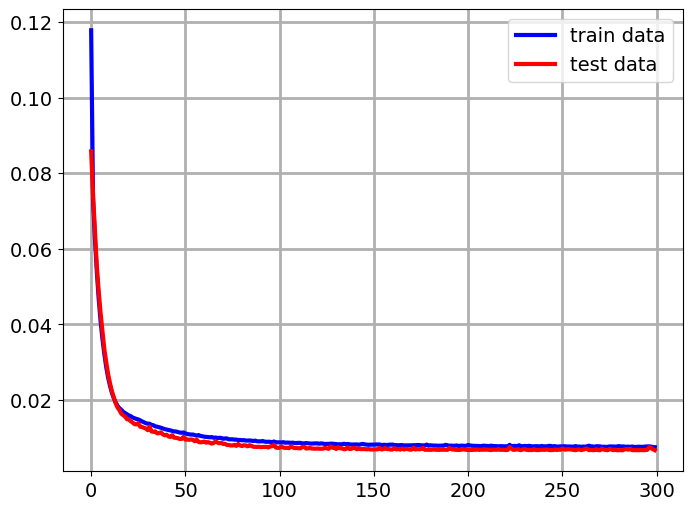

0

In [15]:
model.plot()

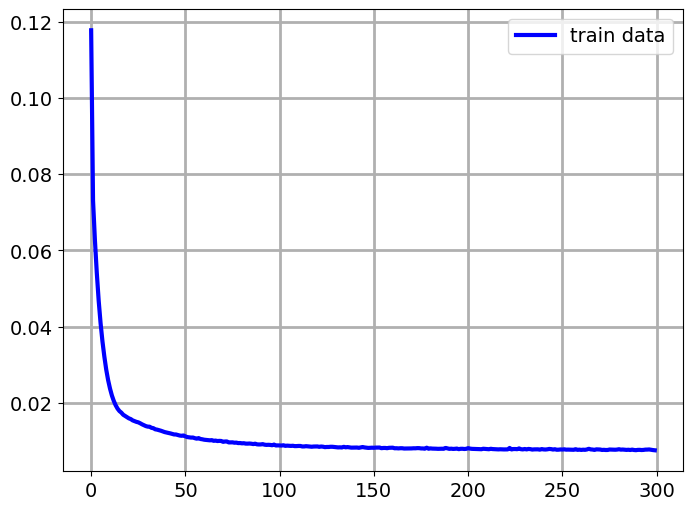

0

In [16]:
model.plot_train()

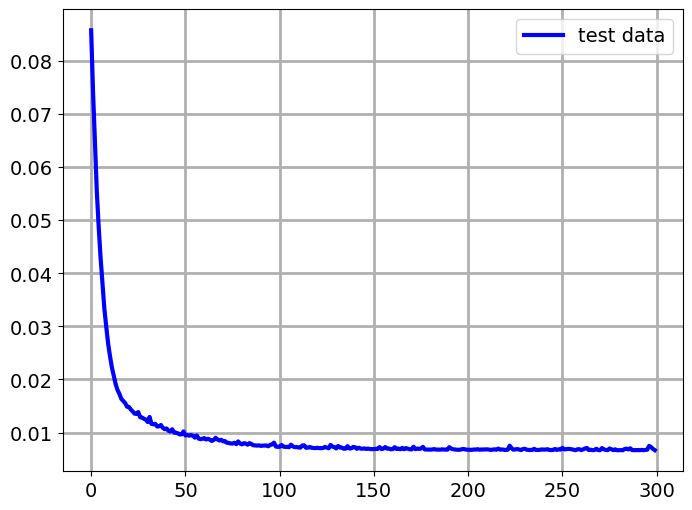

0

In [17]:
model.plot_test()